This part selects 10k files from each folder

In [9]:
import os
import random
import pandas as pd
import json

folder_path1 = 'E:\document_parses\pdf_json'
folder_path2 = 'E:\document_parses\pmc_json'

all_files1 = [f for f in os.listdir(folder_path1) if f.endswith('.json')]
all_files2 = [f for f in os.listdir(folder_path2) if f.endswith('.json')]
total_files1 = len(all_files1)
print("Total number of documents:", total_files1)
total_files2 = len(all_files2)
print("Total number of documents:", total_files2)

selected_files1 = random.sample(all_files1, min(5000, total_files1))

data_frames = []
for file in selected_files1:
    file_path = os.path.join(folder_path1, file)
    with open(file_path, 'r') as f:
        data = json.load(f)
        data_frames.append(pd.DataFrame([data]))

final_df1 = pd.concat(data_frames, ignore_index=True)
selected_files2 = random.sample(all_files2, min(5000, total_files2))

data_frames = []
for file in selected_files2:
    file_path = os.path.join(folder_path2, file)
    with open(file_path, 'r') as f:
        data = json.load(f)
        data_frames.append(pd.DataFrame([data]))

final_df2 = pd.concat(data_frames, ignore_index=True)

df_raw = pd.concat([final_df1, final_df2], ignore_index=True, sort=False)

extracted_data = []
for index, row in df_raw.iterrows():
    paper_id = row['paper_id']
    title = row['metadata']['title']

    for text_entry in row['body_text']:
        text = text_entry['text']
        section = text_entry.get('section', 'Unknown')

        extracted_data.append({
            'text': text,
            'paper_id': paper_id,
            'title': title,
            'section': section
        })

df_clean = pd.DataFrame(extracted_data, columns=['text', 'paper_id', 'title', 'section'])
df_raw.to_csv('../raw.csv', index=True)

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\yaoji\AppData\Local\Temp\ipykernel_8940\825500636.py:6: SyntaxWarning: invalid escape sequence '\d'
  folder_path1 = 'E:\document_parses\pdf_json'
C:\Users\yaoji\AppData\Local\Temp\ipykernel_8940\825500636.py:7: SyntaxWarning: invalid escape sequence '\d'
  folder_path2 = 'E:\document_parses\pmc_json'


Total number of documents: 401212
Total number of documents: 315742


In [10]:
import nltk
from nltk import ngrams, FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string

# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yaoji\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yaoji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Some text cleaning functions: remove special chars, change eos char to space, change multiple space to single space

In [11]:
import re

def clean_text(text):
    pattern = r'[^\w\s,.!?;:\-\']'
    text = re.sub(pattern, '', text)
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

    
df_clean['text'] = df_clean['text'].apply(clean_text)

In [12]:
stop_words = set(stopwords.words('english'))

def clean_tokens(tokens):
    return [token for token in tokens if token.isalpha() and token not in stop_words]

Change first upper case char to lower

In [13]:
def lowercase_first_character(text):
    sentences = sent_tokenize(text)
    adjusted_sentences = [sentence[0].lower() + sentence[1:] if sentence else '' for sentence in sentences]
    return ' '.join(adjusted_sentences)

df_clean['text'] = df_clean['text'].apply(lowercase_first_character)
df_clean = df_clean.dropna(subset=['text'])

Generate unigram, bigram, trigrams for all

In [14]:
from nltk import ngrams
from collections import Counter

stop_words = set(stopwords.words('english'))

def clean_tokens(tokens):
    return [token for token in tokens if token.isalpha() and token not in stop_words]

def generate_ngrams(text, n=3):
    tokens = word_tokenize(text)
    tokens = clean_tokens(tokens)
    all_ngrams = []
    for i in range(1, n+1):
        all_ngrams.extend(ngrams(tokens, i))
    return all_ngrams


df_clean['ngrams'] = df_clean['text'].apply(generate_ngrams)
all_ngrams_series = df_clean['ngrams'].explode()
all_ngrams = all_ngrams_series.tolist()

KeyboardInterrupt: 

In [8]:
df_clean.to_csv('../clean.csv', index=True)

In [9]:
aggregated_ngrams = df_clean.groupby('paper_id')['ngrams'].sum().reset_index()

Perform count on n-grams

In [10]:
import pickle

with open('../all_ngrams.pkl', 'wb') as file:
    pickle.dump(all_ngrams, file)

with open('../all_ngrams.pkl', 'rb') as file:
    all_ngrams = pickle.load(file)

In [11]:
ngram_freq = Counter(all_ngrams)
ngram_freq

Counter({('patients',): 108448,
         ('et',): 100554,
         ('study',): 88229,
         ('also',): 82737,
         ('data',): 79467,
         ('used',): 62087,
         ('may',): 61890,
         ('using',): 61530,
         ('cells',): 60231,
         ('health',): 55875,
         ('one',): 48336,
         ('studies',): 47619,
         ('infection',): 46786,
         ('time',): 46136,
         ('results',): 44598,
         ('disease',): 42881,
         ('two',): 41641,
         ('al',): 41595,
         ('however',): 41465,
         ('et', 'al'): 41182,
         ('use',): 41150,
         ('different',): 40186,
         ('analysis',): 39545,
         ('model',): 39261,
         ('number',): 39105,
         ('reported',): 38874,
         ('virus',): 37613,
         ('pandemic',): 36702,
         ('could',): 36173,
         ('cases',): 35788,
         ('first',): 35104,
         ('risk',): 34896,
         ('clinical',): 34367,
         ('found',): 33290,
         ('high',): 32369,
   

In [12]:
import pickle

with open('../ngram_freq.pkl', 'wb') as file:
    pickle.dump(ngram_freq, file)

In [3]:
import pickle
with open('../ngram_freq.pkl', 'rb') as file:
    ngram_freq = pickle.load(file)

In [15]:
import numpy as np
df_dict = {}
for ngrams_list in aggregated_ngrams['ngrams']:
    for ngram in set(ngrams_list):
        df_dict[ngram] = df_dict.get(ngram, 0) + 1

# Step 3 & 4: Calculate IDF for each n-gram
N = len(aggregated_ngrams)
idf = {ngram: np.log((1 + N) / (1 + df)) + 1 for ngram, df in df_dict.items()}

# Function to calculate TF for each n-gram in a document
def calculate_tf(ngrams_list):
    ngram_counts = pd.Series(ngrams_list).value_counts()
    tf = ngram_counts / len(ngrams_list)
    return tf

# Function to calculate TF-IDF for each n-gram in a document
def calculate_tf_idf(ngrams_list):
    tf = calculate_tf(ngrams_list)
    tf_idf = {ngram: (tf_val * idf[ngram]) for ngram, tf_val in tf.items()}
    return tf_idf

# Step 5: Calculate TF-IDF for each n-gram in each document
aggregated_ngrams['tf_idf'] = aggregated_ngrams['ngrams'].apply(calculate_tf_idf)

# Step 6: (Optional) Aggregate TF-IDF scores for each n-gram across all documents
tf_idf_aggregated = {}
for index, row in aggregated_ngrams.iterrows():
    for ngram, score in row['tf_idf'].items():
        if ngram in tf_idf_aggregated:
            tf_idf_aggregated[ngram] += score
        else:
            tf_idf_aggregated[ngram] = score

In [20]:
len(aggregated_ngrams)

10000

In [17]:
len(tf_idf_aggregated)

25176598

In [19]:
import pickle

with open('../tf_idf_aggregated.pkl', 'wb') as file:
    pickle.dump(tf_idf_aggregated, file)

In [15]:
import pickle
with open('../tf_idf_aggregated.pkl', 'rb') as file:
    tf_idf_aggregated = pickle.load(file)

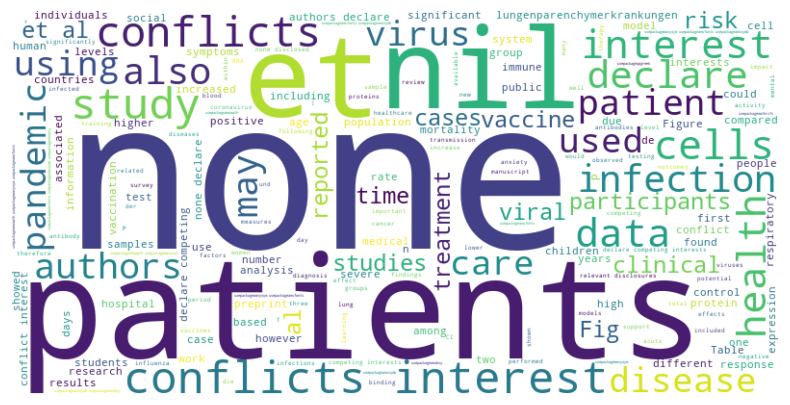

In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Step 1: Convert n-grams from tuples to strings and prepare the data for the WordCloud
# Assuming `tf_idf_aggregated` is your dictionary with n-grams as keys and aggregated TF-IDF scores as values
ngram_str_scores = {' '.join(ngram): score for ngram, score in tf_idf_aggregated.items()}

# Step 2: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(ngram_str_scores)

# Step 3: Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

The part below follows the kaggle tutorial

In [1]:
import re
import pandas as pd
import requests
import spacy
from spacy import displacy


from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
nlp = spacy.load("en_core_web_md")

In [4]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [[{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]]

  matcher.add("matching_1", pattern) 

  matches = matcher(doc)
  if matches:
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]
        return span.text
  else:
        return None

In [20]:
df = pd.read_csv("../clean.csv")
df = df.dropna(subset=['text'])

In [21]:
df = df[['paper_id', 'text', 'section']]

In [38]:
from nltk.tokenize import sent_tokenize
import pandas as pd

df['text'] = df['text'].apply(sent_tokenize)
df = df.explode('text')
df.to_csv("../sent.csv")

In [5]:
df = pd.read_csv("../sent.csv")

In [6]:
def get_entities(texts):
  entities = []
  for doc in tqdm(nlp.pipe(texts, batch_size=20), total=len(texts)):
    ## chunk 1
    ent1 = ""
    ent2 = ""
    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence
    prefix = ""
    modifier = ""

    
    for tok in doc:
      ## chunk 2
      # if token is a punctuation mark then move on to the next token
      if tok.dep_ != "punct":
        # check: token is a compound word or not
        if tok.dep_ == "compound":
          prefix = tok.text
          # if the previous word was also a 'compound' then add the current word to it
          if prv_tok_dep == "compound":
            prefix = prv_tok_text + " "+ tok.text
        
        # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
          modifier = tok.text
          # if the previous word was also a 'compound' then add the current word to it
          if prv_tok_dep == "compound":
            modifier = prv_tok_text + " "+ tok.text
        
        ## chunk 3
        if tok.dep_.find("subj") == True:
          ent1 = modifier +" "+ prefix + " "+ tok.text
          prefix = ""
          modifier = ""
          prv_tok_dep = ""
          prv_tok_text = ""      

        ## chunk 4
        if tok.dep_.find("obj") == True:
          ent2 = modifier +" "+ prefix +" "+ tok.text
          
        ## chunk 5  
        # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
    entities.append([ent1.strip(), ent2.strip()])

  return entities

In [7]:
texts = df['text'].tolist()

In [8]:
entities_list = get_entities(texts)

  1%|          | 13240/1428315 [00:35<1:02:21, 378.25it/s]


KeyboardInterrupt: 

In [20]:
import pickle
with open('../entities_list.pkl', 'wb') as f:
    pickle.dump(entities_list, f)

In [ ]:
import pickle
with open('../entities_list.pkl', 'rb') as file:
    entities_list = pickle.load(file)

In [10]:
relations = [get_relation(i) for i in tqdm(df['text'])]

  1%|▏         | 20772/1428315 [02:23<2:18:24, 169.50it/s]

In [ ]:
import pickle
with open('../relations_list.pkl', 'wb') as f:
    pickle.dump(relations, f)

In [ ]:
pd.Series(relations).value_counts()[:50]

In [ ]:
source = [i[0] for i in entities_list]

# extract object
target = [i[1] for i in entities_list]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()